# Rate limiting in async code

This post describes three ways to rate limit async code in a way that optimizes for throughput and latency. The first two methods use native asyncio primitives, while the third uses aiochan, a third-party library that is meant to provide functionality similar to channels in Go.

## Definitions

A few definitions to set the context for this post:

- "rate limit" means to limit the number of operations per period
- "operations" is the number of times a function is called in a given period
- "period" is the time window in which the number of operations is limited

## Setup

Typically, rate limiting is used in the context of a web server. For this post, I'll use a function that returns a timestamp to mock the request to the server. I'll also have that function sleep for a random amount of time to simulate the work that the server is doing.

In [12]:
import asyncio

import httpx
import pendulum as pdl
from contextlib import asynccontextmanager
import time
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

I would like to make the mocked function as realistic as possible. So I'll figure out the distribution of times to return a call from httpbin.

In [2]:
def now():
    return int(pdl.now().format("x"))

<AxesSubplot: >

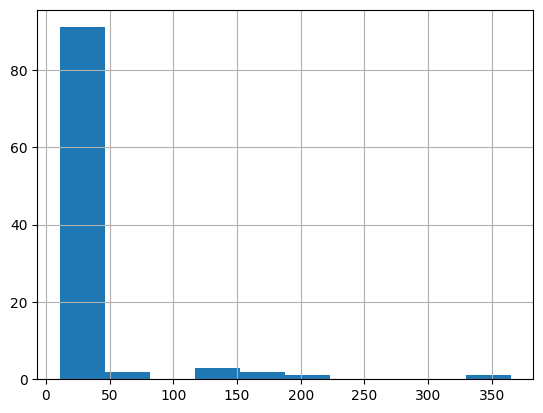

In [4]:
times = []
for i in range(10):
    for i in range(10):
        start = now()
        httpx.get('http://httpbin.org/get')
        times.append(now() - start)
    time.sleep(1)

times_per_request = pd.Series(times)
times_per_request.hist()

In [39]:
def create_server(times: np.ndarray):

    async def server(num, start, limiter):
        time = np.random.choice(times)
        # Times are in milliseconds
        async with limiter():
            await asyncio.sleep(time / 1000)
            return (num, start, now())
    return server

server = create_server(times_per_request.values)

## Method 1: simple semaphore context manager

This is the simplest way to rate limit async code. It uses a semaphore to limit the number of concurrent tasks, and a context manager to ensure that the semaphore is released when the task is done. At the end of each task, the context manager sleeps for the required period before releasing the semaphore.

In [40]:

def create_simple_rate_limiter(max_requests, period):
    """Create a rate limiter that limits the number of requests to `max_requests` per `period` seconds."""
    sem =  asyncio.Semaphore(max_requests)

    @asynccontextmanager
    async def rate_limiter():
        try:
            await sem.acquire()
            yield
        finally:
            await asyncio.sleep(period)
            sem.release()
    return rate_limiter

    

In [41]:
simple_limiter = create_simple_rate_limiter(5, 1)

In [45]:
times = []

tasks = [server(num, now(), simple_limiter) for num in range(10)]
task_iter = asyncio.as_completed(tasks)

for task in task_iter:
    num, start, returned = await task
    finished = now()

    times.append([num, start, returned, finished])

In [46]:
simple_times_df = pd.DataFrame(
    times, 
    columns=['request', 'start', 'returned', 'end']
    ).melt(id_vars=['request'], var_name='time', value_name='time_ms')

simple_times_df.head()

,request,time,time_ms
0,4,start,1669485213138
1,1,start,1669485213138
2,3,start,1669485213138
3,9,start,1669485213138
4,0,start,1669485213138


In [47]:
px.scatter(simple_times_df, x='request', y='time_ms', color='time')

A few observations:

1. The start times are all about the same, this is what we'd expect.
2. There are five returned times that are almost instant and five that are returned after about one second. This is also exepected since the rate limiter releases the semaphore every second.
3. The end times are are all about one second after the returned time. This is not good behaviour, since it would block anything that comes after the rate limiter.

The third point happens because the context manager can't exit until after the sleep time.

## Method 2: Using a "sleeper" task
